In [8]:
import torch
import gym
import random
from collections import deque, namedtuple
from matplotlib import pyplot as plt


In [9]:
replayItem = namedtuple('replayItem', ('state', 'action', 'reward', 'next_state', 'done'))
class ReplayMemory:
    def __init__(self, capacity) -> None:
        self.memory = deque(maxlen=capacity)

    def append(self, *args) -> None:
        self.memory.append(replayItem(*args))

    def sample(self, batch_size) -> list:
        return random.sample(self.memory, batch_size)
    
    def __len__(self) -> int:
        return len(self.memory)

In [10]:
class DQN(torch.nn.Module):
    def __init__(self, layer_sizes) -> None:
        super().__init__()
        self.layers = torch.nn.Sequential()
        for i in range(len(layer_sizes)-1):
            self.layers.add_module(f'layer{i}', torch.nn.Linear(layer_sizes[i], layer_sizes[i+1]))
            if i < len(layer_sizes)-2:
                self.layers.add_module(f'relu{i}', torch.nn.ReLU())
        
    def forward(self, x)->torch.Tensor:
        return self.layers(x)

In [11]:
def epsilon_greedy_action(epsilon, action_rewards)->int:
    if random.random() < epsilon:
        return random.randint(0, len(action_rewards)-1)
    else:
        return torch.argmax(action_rewards).item()

In [12]:
def loss_func(policy_model, target_model, states, actions, rewards, next_states, dones, gamma):
    states = torch.tensor(states, dtype=torch.float32)
    next_states = torch.tensor(next_states, dtype=torch.float32)

    actions = torch.tensor(actions, dtype=torch.int64).reshape(-1, 1)
    rewards = torch.tensor(rewards, dtype=torch.float32).reshape(-1, 1)
    dones = torch.tensor(dones, dtype=torch.float32).reshape(-1, 1)
    
    q_values = policy_model.forward(states).gather(1, actions)
    next_q_values = target_model.forward(next_states).max(dim=1, keepdim=True)[0]
    expected_q_values = rewards + gamma * next_q_values * (1 - dones)
    loss = torch.nn.functional.mse_loss(q_values, expected_q_values)
    return loss

In [15]:
env = gym.make('CartPole-v1')

gamma = 1
epsilon = 1.0
epsilon_min = 0.01
epsilon_decay = 0.99
batch_size = 64
memory_size = 50000
num_episodes = 300
target_update_rate = 5
        
input_shape = env.observation_space.shape
output_shape = env.action_space.n
hideen_layers = [64, 64]

gradient_clipping_value = 1

model_shape = [*input_shape, *hideen_layers, output_shape]


memory = ReplayMemory(memory_size)
policy_model = DQN(model_shape)
target_model = DQN(model_shape)
target_model.load_state_dict(policy_model.state_dict())

optimizer = torch.optim.Adam(policy_model.parameters(), lr=0.0001)

  
episode_steps = []           
for i in range(num_episodes):
    state, _ = env.reset()
    steps = 0
    while True:
        steps+=1
        qs = policy_model.forward(torch.Tensor(state))
        action = epsilon_greedy_action(epsilon, qs)
        
        next_observation, reward, done, _, _ = env.step(action)
        
        memory.append(state, action, reward, next_observation, done)
        state = next_observation
        
        if done:
            break
        
        if len(memory) > batch_size:
            batch = memory.sample(batch_size)
            states, actions, rewards, next_states, dones = zip(*batch)
            loss = loss_func(policy_model, target_model, states, actions, rewards, next_states, dones, gamma)
            
            policy_model.zero_grad()
            loss.backward()
            # gradient clipping
            torch.nn.utils.clip_grad_norm_(policy_model.parameters(), gradient_clipping_value)
            optimizer.step()
            
            if steps % target_update_rate == 0:
                target_model.load_state_dict(policy_model.state_dict())
            
    epsilon = max(epsilon_min, epsilon_decay * epsilon)
    episode_steps.append(steps)
    if (i+1) % 100 == 0:
        print(f'Episode {i+1}: {sum(episode_steps[-100:])/100}')
        
    

Episode 100: 14.88
Episode 200: 11.01
Episode 300: 31.95


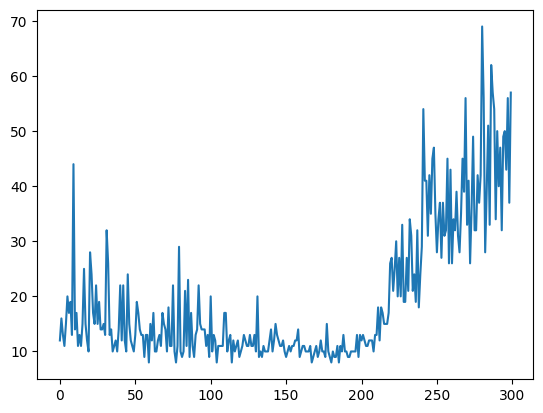

In [16]:
plt.plot(episode_steps)